# Learning Soft Constraints using Apprenticeship Learning

## General Setup and Imports

Propagate code changes into notebook

In [166]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [167]:
%matplotlib inline

In [168]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvas
# allow us to re-use the framework from the src directory
import sys, os
sys.path.append(os.path.abspath(os.path.join('../')))
from collections import namedtuple, defaultdict

In [169]:
import max_ent.examples.grid_3_by_3 as G
from max_ent.gridworld import Directions
#%matplotlib notebook      commenting this out enables inline plotting
np.random.seed(123)

## Gridworld Setup

The following function sets up the gridworld environment. The gridworld is a 2D grid with a start and goal state. The fig object is also returned now as the last parameter, and if this is saved you can view the images of the world. 

In [170]:
Demonstration = namedtuple('Demonstration', ['trajectories', 'policy'])

In [171]:
def create_world(title, blue, green, cs=[], ca=[], cc=[], start=0, goal=2, vmin=-50, vmax=10):
    n_cfg = G.config_world(blue, green, cs, ca, cc, goal)
    n = n_cfg.mdp

    # Generate demonstrations and plot the world
    demo = G.generate_trajectories(n.world, n.reward, n.start, n.terminal) 
    #test_demo = Demonstration(demo.trajectories[0:2], demo.policy)
    vmin = -50
    vmax = 10
    G.plot_world(title, n, n_cfg.state_penalties,
           n_cfg.action_penalties, n_cfg.color_penalties,
           demo, n_cfg.blue, n_cfg.green, vmin=vmin, vmax=vmax)
    return n, n_cfg, demo

### Nominal World

{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x132d7b350>}


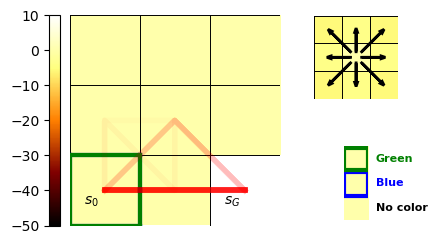

In [172]:
blue = [0]  # blue states
green = [0]  # green states

n, n_cfg, demo_n = create_world('Nominal', blue, green)

### Constrained World Creation

{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x132d7b350>}


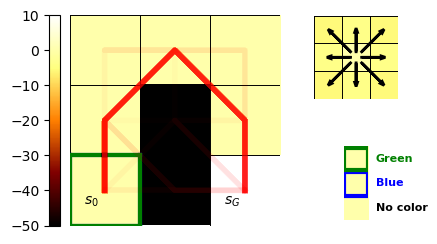

In [173]:
cs = [1, 4]  # constrained states
ca = []  # constrained actions
cc = []  # constrained colors

c, c_cfg, demo_c = create_world('Constrained', blue, green, cs, ca, cc)

## Algorithm

### Algorithm Specific Imports

In [174]:
import max_ent.optim as O
from max_ent.algorithms import rl as RL
from numpy.linalg import norm
import math
import max_ent.gridworld.trajectory as T
import scipy.special 

### Helper Functions

In [175]:
def fe_from_trajectories(features, trajectories, discount):
    """
    Compute the empirical feature expectations from a set of trajectories.

    param features: feature matrix of shape (n_states, n_actions, n_states, n_features)
    param trajectories: list of trajectory instances containing array 
                        of (state, action, next_state) tuples
    param discount: discount factor

    return: averaged discounted feature expectations
    """
    n_features = features.shape[-1]

    fe = np.zeros(n_features)

    for t in trajectories:
        time_step = 1
        for s, a, s_ in t.transitions():
            fe += features[s, a, s_, :] * (discount ** time_step)
            time_step += 1

    return fe / len(trajectories)

In [176]:
def value_iteration(p, reward, discount, eps=1e-3):
    """
    Basic value-iteration algorithm to solve the given MDP.

    Args:
        p: The transition probabilities of the MDP as table
            `[from: Integer, to: Integer, action: Integer] -> probability: Float`
            specifying the probability of a transition from state `from` to
            state `to` via action `action` to succeed.
        reward: The reward signal per state as table
            `[state: Integer, action: Integer] -> reward: Float`.
        discount: The discount (gamma) applied during value-iteration.
        eps: The threshold to be used as convergence criterion. Convergence
            is assumed if the value-function changes less than the threshold
            on all states in a single iteration.

    Returns:
        The value function as table `[state: Integer] -> value: Float` and
        the q-value function as table `[state: Integer, actiuon: Integer] -> value: Float`
    """
    n_states, _, _ = p.shape
    v = np.zeros(n_states)
    p_t = np.moveaxis(p, 1, 2)

    delta = np.inf
    q = 0
    while delta > eps:      # iterate until convergence
        v_old = v

        # compute state-action values (note: we actually have Q[a, s] here)
        # sum over the destination states
        q = (p_t * (discount * v[None, None, :] + reward)).sum(-1)

        # compute state values
        v = np.max(q.T, axis=0)

        # compute maximum delta
        delta = np.max(np.abs(v_old - v))

    return q, v

In [177]:
def stochastic_policy_from_q_value(world, q_value, w=lambda x: x):
    """
    Compute a stochastic policy from the given q-value function.
    Args:
        world: The `GridWorld` instance for which the the policy should be
            computed.
        q_value: The q_value-function dictating the policy as table
            `[state: Integer, action: Integer] -> value: Float`
        w: A weighting function `(value: Float) -> value: Float` applied to
            all state-action values before normalizing the results, which
            are then used as probabilities. I.e. choosing `x -> 2*x` here
            will cause the preference of suboptimal actions to decrease
            quadratically compared to the preference of the optimal action 
            as we are using a softmax distribution.
    Returns:
        The stochastic policy given the provided arguments as table
        `[state: Integer, action: Integer] -> probability: Float`
        describing a probability distribution p(action | state) of selecting
        an action given a state.
    """
    return scipy.special.softmax(w(q_value), 1)

In [178]:
def stochastic_policy_adapter(policy):
    """
    A policy adapter for stochastic policies.

    Adapts a stochastic policy given as array or map
    `policy[state, action] -> probability` for the trajectory-generation
    functions.

    Args:
        policy: The stochastic policy as map/array
            `policy[state: Integer, action: Integer] -> probability`
            representing the probability distribution p(action | state) of
            an action given a state.

    Returns:
        A function `(state: Integer) -> action: Integer` acting out the
        given policy, choosing an action randomly based on the distribution
        defined by the given policy.
    """
    return lambda state: np.random.choice([*range(policy.shape[1])], p=policy[state, :])

### Parameters

In [179]:
discount=0.9
clip_grad_at=10
lr=0.3
max_iter=500
burn_out=50
eps=1e-4
log=None
initial_omega=None
init = O.Constant(1e-6)
optim = O.ExpSga(lr=lr, clip_grad_at=clip_grad_at)
start = [0]
burnout = 25

In [180]:
nominal_rewards = n.reward
world = c.world
terminal = c.terminal
trajectories = demo_c.trajectories
p_transition = world.p_transition
features = world.phi

Setting up initial probabilities for trajectory generation

In [181]:
initial = np.zeros(world.n_states)
initial[start] = 1.0

### Learning

First, initialize some variables and compute empirical variables.

In [182]:
n_states, n_actions, _, n_features = features.shape
features[terminal] = 0  #can't transition from a terminal state
nominal_rewards = np.array(nominal_rewards)  # nominal reward vector is already known


In [183]:
features.shape

(9, 8, 9, 20)

Compute the empirical estimate for $\mu_e$. This is algorithm 5 from the [NG paper](https://ai.stanford.edu/~ang/papers/icml04-apprentice.pdf).

In [184]:
fe_expert = fe_from_trajectories(features, trajectories, discount)

Step 3 of MESC-IRL

In [185]:
omega_r = np.zeros(n_features)
reward_c = nominal_rewards - features @ omega_r

In [186]:
policy_list  = []
margin = []
fe_current = []
fe_bar = []
omega_c = []

In [187]:
from collections import namedtuple, defaultdict
Demonstration = namedtuple('Demonstration', ['trajectories', 'policy'])

Step 1 of NG algorithm. Randomly pick some policy, compute the feature expectation.

In [188]:
q_function, v_function = value_iteration(p_transition, reward_c, discount)
policy = stochastic_policy_from_q_value(world, q_function) #get policy from running RL with initial reward function
policy_exec = stochastic_policy_adapter(policy)
policy_list.append(policy)

In [190]:
q_function

array([[36.44467036, 44.73115844, 35.02509704, 36.44467036, 34.78781611,
        41.42194793, 34.78781611, 34.78781611],
       [37.03886467, 54.96139063, 43.67299649, 45.32535275, 33.9624371 ,
        43.6684985 , 43.6684985 , 43.6684985 ],
       [46.11058471, 55.74662259, 46.11058471, 55.74662259, 42.8013742 ,
        54.08976834, 54.08976834, 54.08976834],
       [34.92489365, 42.97859879, 33.38854251, 36.34446697, 33.2680394 ,
        33.2680394 , 33.2680394 , 42.97410079],
       [35.2361996 , 44.942261  , 35.2361996 , 44.942261  , 32.04299422,
        34.99891867, 34.99891867, 52.92144464],
       [43.67299649, 45.32535275, 37.03886467, 54.96139063, 33.9624371 ,
        43.6684985 , 43.6684985 , 43.6684985 ],
       [33.14866697, 34.6850181 , 33.14866697, 34.6850181 , 31.49181272,
        31.49181272, 31.49181272, 41.08186899],
       [33.38854251, 36.34446697, 34.92489365, 42.97859879, 33.2680394 ,
        33.2680394 , 33.2680394 , 42.97410079],
       [35.02509704, 36.44467036

In [189]:
sample_tjs = None
new_policy = None
q_new = None
for i in range(200):

    #get latest policy
    policy = policy_list[-1]

    #Compute feature expectations of new policy and add to list
    if i==0:
        sample_tjs = T.generate_trajectories(1000, world, policy_exec, initial, terminal) #get sample trajectories from initial policy
        fe_current.append(fe_from_trajectories(features, sample_tjs, discount)) # get feature expectation of initial policy using sampled trajectories
        margin.append(1) # dummy margin to start
        omega_c.append(np.zeros(n_features)) # dummy omega_c to start
    else:
        if i==1:
            fe_bar.append(fe_current[i-1])
            omega_c.append(fe_expert - fe_current[i-1])
            margin.append(norm((fe_expert-fe_bar[i-1]), 2))
        else:
            A = fe_bar[i-2]
            B = fe_current[i-1]-A
            C = fe_expert - fe_bar[i-2]
            fe_bar.append(A+(np.dot(B,C)/np.dot(B,B))*(B))
            omega_c.append(fe_expert - fe_bar[i-1])
            margin.append(norm((fe_expert-fe_bar[i-1]), 2))
            print("margin: ", margin[i])

        reward_c = features @ omega_c[i]
        q_new, v_new = value_iteration(p_transition, reward_c, discount)
        new_policy = stochastic_policy_from_q_value(world, q_new)  # (s, a) -> p(a | s)
        new_policy_exec = stochastic_policy_adapter(new_policy)
        policy_exec = new_policy_exec
        policy_list.append(new_policy)
        sample_tjs = T.generate_trajectories(1000, world, policy_exec, initial, terminal)
        fe_current.append(fe_from_trajectories(features, sample_tjs, discount))


margin:  1.7335759979958152
margin:  1.6763712909284287
margin:  1.6761496362918062
margin:  1.6761206572738068
margin:  1.6760664176830649
margin:  1.676056617995333
margin:  1.6758901442834353
margin:  1.675412337360649
margin:  1.6749921295946406
margin:  1.67492542299382
margin:  1.6748887284188274
margin:  1.6746430292825294
margin:  1.6744734565109558
margin:  1.6744280136522454
margin:  1.6743180690005344
margin:  1.6742849120184529
margin:  1.6742678260708397
margin:  1.6742548532078914
margin:  1.6742458341261555
margin:  1.674231005529269


KeyboardInterrupt: 

Order of actions:   left, right, up, down, up-left, up-right, down-left, down-right

In [124]:
omega_c[-1]

array([-0.26259276, -0.54672605,  0.08024347,  0.22711671, -0.2467967 ,
        0.35950976, -0.17814496, -0.06309332, -0.09170741, -0.21501835,
       -1.00127165,  0.22869904,  0.30309748, -0.26591903,  0.14765603,
       -0.2244523 ,  0.30501752, -0.4595985 ,  0.        , -0.26259276])

In [129]:
fe_current[-1]

array([1.65694847, 0.52534006, 0.27948315, 1.06182795, 0.6689225 ,
       0.74125476, 0.3971093 , 0.67267453, 0.48109092, 0.59727196,
       0.34907869, 1.07429695, 1.00136373, 0.64891959, 1.1185649 ,
       0.5576845 , 1.13747132, 4.82770317, 0.        , 1.65694847])

In [126]:
fe_expert

array([0.10449   , 0.0756    , 0.64159112, 0.884241  , 0.046512  ,
       0.65564802, 0.04536   , 0.7379019 , 0.0343359 , 0.009     ,
       0.116154  , 0.976041  , 0.62098553, 0.        , 0.7958169 ,
       0.        , 0.70768251, 3.12118994, 0.        , 0.10449   ])

Plotting function to visualize trajectories at any point in algorithm.

{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x132d7b350>}


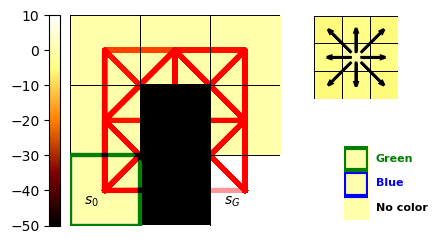

In [127]:
n_cfg = G.config_world(blue, green, cs, ca, cc, 2)
n = n_cfg.mdp


G.plot_world('test', c, c_cfg.state_penalties,
           n_cfg.action_penalties, n_cfg.color_penalties,
           Demonstration(sample_tjs, policy_list[-1]), n_cfg.blue, n_cfg.green, vmin=-50, vmax=10);